In [1]:
import os
import sys
import glob
import subprocess
import numpy as np
import pandas as pd

import scanpy as sc
from pathlib import Path

from pyroe import load_fry

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [7]:
base_dir = Path.cwd().parent
seq_dir = base_dir+"seqdata/"
data_dir = base_dir+"data/"
soft_dir = base_dir+"soft/"
outdir = base_dir+"exp.umi/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

r1_fname = seq_dir+"R2_processed.fastq"
r2_fname = seq_dir+"R1_filtered.fastq.gz"

barcodes_fname = seq_dir+"spatial_barcodes.only.txt"

mmul10_fasta_fname = data_dir+"Macaca_mulatta.Mmul_10.dna.toplevel.fa"
mmul10_gff_fname = data_dir+"Macaca_mulatta.Mmul_10.110.gtf"
mmul10_resfeq_gff_fname = data_dir+"Mmul_10_genomic.gtf"

num_threads = 24

In [8]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "../scripts/genomic_scripts/")
%aimport definitions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# test different UMI resolution strategies between stp, star and alevin.

In [10]:
# start by isolating the same set of reads from a run of st pipeline (trimmed and filtered and mapped before annotation)

In [11]:
# load barcode reads into memory (read name: sequence,qual)

umi_fname = seq_dir+"RNA/processed.Kristen/RDW9M8V1_R2_processed.fastq"
cdna_fname = seq_dir+"RNA/processed.Kristen/RDW9M8V1_R1_filtered.fastq"

umi_reads = definitions.load_fastq_dict(umi_fname,True)

In [12]:
len(umi_reads)

203229968

In [18]:
# extract fastq from bam using samtools
stp_mapped_fastq_fname = outdir+"stp.mapped.fastq"
outFP = open(stp_mapped_fastq_fname,"w+")

cmd = ["samtools","bam2fq","/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.stp_reads/stp.AdjacentBi.6.hamming.splice.noamb.qual20/tmp/mapped.bam"]
subprocess.call(cmd,stdout=outFP)

outFP.close()

[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 65400662 reads


In [19]:
# for every extracted read from bam, write a umi read into separate file from the loaded dict

stp_bc_fastq_fname = outdir+"stp.mapped.bc.fastq"

with open(stp_bc_fastq_fname,"w+") as outFP:
    with open(stp_mapped_fastq_fname,"r") as inFP:
        for line in inFP:
            if line[0]=="@":
                rname = line[1:].strip()
                assert rname in umi_reads,"read not found: "+rname
                
                outFP.write(umi_reads[rname])

In [20]:
# build alignment commands

from concurrent.futures import ThreadPoolExecutor

def execute_commands(commands):
    for cmd in commands:
        print(" ".join([str(x) for x in cmd]))
        subprocess.call([str(x) for x in cmd])

def run_parallel_commands(command_lists):
    with ThreadPoolExecutor() as executor:
        executor.map(execute_commands, command_lists)

In [29]:
# pre-compute base steps of alevin (these do not need to be repeated for the UMI tests)
OUTPUT = outdir+"ALEVIN/"
barcodes_fname = seq_dir+"spatial_barcodes.only.txt"

# run salmon alevin
alevin_map_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/salmon-latest_linux_x86_64/bin/salmon","alevin",
       "--index",mmul10_gff_fname.rstrip(".gtf")+".mod.type.ALEVIN/index",
       "-l","A",
       "-1",stp_bc_fastq_fname,
       "-2",stp_mapped_fastq_fname,
       "--read-geometry","2[1-end]",
       "--bc-geometry","1[1-8,9-16]",
       "--umi-geometry","1[17-26]",
       "--threads","6",
       "-o",OUTPUT+"af_map",
       "--sketch"]

alevin_gen_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry","generate-permit-list",
       "-i",OUTPUT+"af_map",
       "--unfiltered-pl",barcodes_fname,
       "--expected-ori","fw",
       "-o",OUTPUT+"af_quant"]

alevin_col_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry","collate",
       "-i",OUTPUT+"af_quant",
       "-r",OUTPUT+"af_map",
       "-t",str(num_threads)]

alevin_cmds = [alevin_map_cmd,alevin_gen_cmd,alevin_col_cmd]
cmd_lst = [alevin_cmds]
run_parallel_commands(cmd_lst)

/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/salmon-latest_linux_x86_64/bin/salmon alevin --index /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/data/Macaca_mulatta.Mmul_10.110.mod.type.ALEVIN/index -l A -1 /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.mapped.bc.fastq -2 /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.mapped.fastq --read-geometry 2[1-end] --bc-geometry 1[1-8,9-16] --umi-geometry 1[17-26] --threads 6 -o /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_map --sketch


Version Info: This is the most recent version of salmon.
[2023-11-21 18:07:29.736] [alevinLog] [info] currently, --sketch implies --rad. Running in alignment-only mode (will write a RAD output).
[2023-11-21 18:07:29.736] [alevinLog] [info] The --rad flag was passed to alevin. The reads will be selectively aligned and the output written to a RAD file.Arguments passed that correspond to other processing steps will be ignored
[2023-11-21 18:07:29.736] [alevinLog] [info] The --sketch flag was passed; the alignment will be run in sketch mode.
Logs will be written to /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_map/logs
### alevin (dscRNA-seq quantification) v1.10.0
### [ program ] => salmon 
### [ command ] => alevin 
### [ index ] => { /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/data/Macaca_mulatta.Mmul_10.110.mod.type.ALEVIN/index }
### [ libType ] => { A }
### [ mates1 ] => { /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.mapped.bc.fastq }
### [ mates2 ] => { /ccb/salz4-4/avaraby

/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry generate-permit-list -i /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_map --unfiltered-pl /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/seqdata/spatial_barcodes.only.txt --expected-ori fw -o /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_quant


2023-11-21 18:09:55 INFO number of unfiltered bcs read = 2,500
2023-11-21 18:09:55 INFO paired : false, ref_count : 92,734, num_chunks : 8,421
2023-11-21 18:09:55 INFO read 2 file-level tags
2023-11-21 18:09:55 INFO read 2 read-level tags
2023-11-21 18:09:55 INFO read 1 alignemnt-level tags
2023-11-21 18:09:55 INFO File-level tag values FileTags { bclen: 16, umilen: 10 }
2023-11-21 18:09:58 INFO observed 42,103,511 reads (38,761,359 orientation consistent) in 8,421 chunks --- max ambiguity read occurs in 2,297 refs
2023-11-21 18:09:58 INFO minimum num reads for barcode pass = 10
2023-11-21 18:09:58 INFO num_passing = 2,493
2023-11-21 18:09:58 INFO found 2,493 cells with non-trivial number of reads by exact barcode match
2023-11-21 18:09:59 INFO There were 680388 distinct unmatched barcodes, and 94137 that can be recovered
2023-11-21 18:09:59 INFO Matching unmatched barcodes to retained barcodes took 225.082745ms
2023-11-21 18:09:59 INFO Of the unmatched barcodes
2023-11-21 18:09:59 INF

/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry collate -i /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_quant -r /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_map -t 24


2023-11-21 18:09:59 INFO deserialized correction map of length : 96,630
2023-11-21 18:09:59 INFO Generated 28 temporary buckets.
2023-11-21 18:10:03 INFO writing num output chunks (2,493) to header
2023-11-21 18:10:03 INFO expected number of output chunks 2,493
2023-11-21 18:10:03 INFO finished collating input rad file "/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_map/map.rad".


In [30]:
# construct commands for evaluation

In [31]:
# STARsolo
barcodes_fname = seq_dir+"spatial_barcodes.only.txt"
ANN=mmul10_gff_fname.rstrip(".gtf")+".mod.type.gtf"
REF=mmul10_gff_fname.rstrip(".gtf")+".mod.type.STAR"
WL=barcodes_fname
CBLEN=16
UMILEN=10
STRAND="Forward"

star_base_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/STAR/Linux_x86_64_static/STAR",
               "--runThreadN","5",
               "--genomeDir",REF,
               "--readFilesIn",stp_mapped_fastq_fname,stp_bc_fastq_fname,
               "--soloType","CB_UMI_Simple",
               "--soloCBwhitelist",WL,
               "--soloCBstart","1",
               "--soloCBlen",str(CBLEN),
               "--soloUMIstart",str(CBLEN+1),
               "--soloUMIlen",str(UMILEN),
               "--soloStrand",STRAND,
               "--soloCBmatchWLtype","1MM_multi_Nbase_pseudocounts",
               "--soloCellFilter","EmptyDrops_CR",
               "--outFilterScoreMin","30",
               "--clipAdapterType","CellRanger4",
               "--soloFeatures","Gene","GeneFull",
               "--soloOutFileNames","solo","features.tsv","barcodes.tsv","matrix.mtx",
               "--soloMultiMappers","EM"]


# STARsolo
OUTPUT = outdir+"starsolo.1MM_CR.MultiGeneUMI_CR"
star1_cmd = star_base_cmd+["--outFileNamePrefix",OUTPUT+"/",
                           "--soloUMIdedup","1MM_CR",
                           "--soloUMIfiltering","MultiGeneUMI_CR"]

OUTPUT = outdir+"starsolo.1MM_CR.MultiGeneUMI"
star2_cmd = star_base_cmd+["--outFileNamePrefix",OUTPUT+"/",
                           "--soloUMIdedup","1MM_CR",
                           "--soloUMIfiltering","MultiGeneUMI"]

OUTPUT = outdir+"starsolo.1MM_Directional_UMItools.MultiGeneUMI"
star3_cmd = star_base_cmd+["--outFileNamePrefix",OUTPUT+"/",
                           "--soloUMIdedup","1MM_Directional_UMItools",
                           "--soloUMIfiltering","MultiGeneUMI"]

OUTPUT = outdir+"starsolo.1MM_Directional.MultiGeneUMI"
star4_cmd = star_base_cmd+["--outFileNamePrefix",OUTPUT+"/",
                           "--soloUMIdedup","1MM_Directional",
                           "--soloUMIfiltering","MultiGeneUMI"]

star_cmds = [[star1_cmd],[star2_cmd],[star3_cmd],[star4_cmd]]

In [32]:
# Alevin
alevin_quant1_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry","quant",
       "-i",outdir+"ALEVIN/af_quant",
       "-o",outdir+"ALEVIN/af_quant.cr_like",
       "-t","5",
       "-m",mmul10_gff_fname.rstrip(".gtf")+".mod.type.ALEVIN/index/t2g_3col.tsv",
       "-r","cr-like"]
alevin_quant2_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry","quant",
       "-i",outdir+"ALEVIN/af_quant",
       "-o",outdir+"ALEVIN/af_quant.parsimony",
       "-t","5",
       "-m",mmul10_gff_fname.rstrip(".gtf")+".mod.type.ALEVIN/index/t2g_3col.tsv",
       "-r","parsimony"]
alevin_quant3_cmd = ["/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/alevin-fry-0.8.2/target/release/alevin-fry","quant",
       "-i",outdir+"ALEVIN/af_quant",
       "-o",outdir+"ALEVIN/af_quant.parsimony_gene",
       "-t","5",
       "-m",mmul10_gff_fname.rstrip(".gtf")+".mod.type.ALEVIN/index/t2g_3col.tsv",
       "-r","parsimony-gene"]
alevin_cmds = [[alevin_quant1_cmd],[alevin_quant2_cmd],[alevin_quant3_cmd]]

In [49]:
# lastly, repeat with STPipeline
FW=stp_bc_fastq_fname
RV=stp_mapped_fastq_fname

# References for mapping, annotation and nonRNA-filtering
MAP=mmul10_gff_fname.rstrip(".gtf")+".mod.type.STAR"
ANN=mmul10_gff_fname.rstrip(".gtf")+".mod.type.gtf"

# Barcodes settings
ID=seq_dir+"spatial_barcodes.txt"

# Running the pipeline
stp_base_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/st_pipeline_run.py",
      "--ids",ID,
      "--ref-map",MAP,
      "--ref-annotation",ANN,
      "--expName","RDW9M8V1",
      "--htseq-no-ambiguous",
      "--verbose",
      "--threads","5",
      "--no-clean-up",
      "--umi-start-position","16",
      "--umi-end-position","26",
      "--demultiplexing-mismatches","1",
      "--demultiplexing-kmer","6",
      "--min-intron-size","1",
      "--max-intron-size","200000",
      "--min-length-qual-trimming","20",
      FW,RV]


OUTPUT=outdir+"/stp.AdjacentBi"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp1_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","AdjacentBi"]
stp1_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


OUTPUT=outdir+"/stp.hierarchical"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp2_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","hierarchical"]
stp2_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


OUTPUT=outdir+"/stp.Adjacent"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp3_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","Adjacent"]
stp3_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


OUTPUT=outdir+"/stp.Affinity"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp4_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","Affinity"]
stp4_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


OUTPUT=outdir+"/stp.AdjacentBi.500"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp5_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","AdjacentBi",
                         "--umi-counting-offset","500"]
stp5_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


OUTPUT=outdir+"/stp.AdjacentBi.1000"
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
TMP_ST=OUTPUT+"/tmp"
if not os.path.exists(TMP_ST):
    os.makedirs(TMP_ST)
stp6_cmd = stp_base_cmd+["--output-folder",OUTPUT,
                         "--log-file",OUTPUT+"/RDW9M8V1_log.txt",
                         "--temp-folder",TMP_ST,
                         "--umi-cluster-algorithm","AdjacentBi",
                         "--umi-counting-offset","1000"]
stp6_convert_cmd = [soft_dir+"st_pipeline/build/scripts-3.11/convertEnsemblToNames.py",
                   "--annotation",ANN,
                   "--output",OUTPUT+"/RDW9M8V1_stdata_updated.tsv",OUTPUT+"/RDW9M8V1_stdata.tsv"]


stp_cmds = [[stp1_cmd,stp1_convert_cmd],[stp2_cmd,stp2_convert_cmd],[stp3_cmd,stp3_convert_cmd],[stp4_cmd,stp4_convert_cmd],[stp5_cmd,stp5_convert_cmd],[stp6_cmd,stp6_convert_cmd]]

In [50]:
# Run
cmd_lst = star_cmds+alevin_cmds+stp_cmds

run_parallel_commands(cmd_lst)

/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/soft/st_pipeline/build/scripts-3.11/st_pipeline_run.py --ids /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/seqdata/spatial_barcodes.txt --ref-map /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/data/Macaca_mulatta.Mmul_10.110.mod.type.STAR --ref-annotation /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/data/Macaca_mulatta.Mmul_10.110.mod.type.gtf --expName RDW9M8V1 --htseq-no-ambiguous --verbose --threads 5 --no-clean-up --umi-start-position 16 --umi-end-position 26 --demultiplexing-mismatches 1 --demultiplexing-kmer 6 --min-intron-size 1 --max-intron-size 200000 --min-length-qual-trimming 20 /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.mapped.bc.fastq /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.mapped.fastq --output-folder /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi//stp.AdjacentBi.500 --log-file /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi//stp.AdjacentBi.500/RDW9M8V1_log.txt --temp-folder /ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi//stp.AdjacentBi.500/tmp 

[bam_sort_core] merging from 25 files and 5 in-memory blocks...
[bam_sort_core] merging from 25 files and 5 in-memory blocks...


ST Pipeline, parameters loaded
ST Pipeline, logger created
ST Pipeline, sanity check passed. Starting the run.
input_reads_forward: 65400662
input_reads_reverse: 65400662
reads_after_trimming_forward: 65392301
reads_after_trimming_reverse: 65392301
reads_after_rRNA_trimming: 0
reads_after_mapping: 0
reads_after_annotation: 19011983
reads_after_demultiplexing: 56769991
reads_after_duplicates_removal: 1730578
genes_found: 17484
duplicates_found: 17281405
pipeline_version: 1.8.1
mapper_tool: b'2.7.8a_2021-03-08'
annotation_tool: htseq-count Not available
demultiplex_tool: Taggd Not available
input_parameters: ('LogName', 'STPipeline')('adaptor_missmatches', 0)('allowed_kmer', 6)('allowed_missed', 1)('barcode_start', 0)('clean', False)('compute_saturation', False)('contaminant_index', None)('disable_annotation', False)('disable_barcode', False)('disable_clipping', False)('disable_mapping', False)('disable_multimap', False)('disable_trimming', False)('disable_umi', False)('expName', 'RDW9M8

In [51]:
base_dir = outdir+"starsolo*/*/"
patterns = ['raw/*.tsv', 'raw/*.mtx', 'filtered/*.tsv', 'filtered/*.mtx']
matching_files = []
for pattern in patterns:
    matching_files.extend(glob.glob(os.path.join(base_dir, pattern)))

for fname in matching_files:
    cmd = "gzip --force "+fname
    subprocess.call(cmd,shell=True)

In [43]:
# load annotation
df = definitions.get_attribute(mmul10_gff_fname.rstrip(".gtf")+".gffread.gtf",["gene_id","gene_name"]).drop("tid",axis=1)
df.drop_duplicates(inplace=True)
df["gene_name"] = np.where(df["gene_name"]=="-",df["gene_id"],df["gene_name"])

In [93]:
adata_stp = sc.read("/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/stp.AdjacentBi/RDW9M8V1_stdata_updated.tsv")
adata_stp.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_stp, inplace=True)

In [94]:
adata_star = sc.read_10x_mtx("/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/starsolo.1MM_CR.MultiGeneUMI/soloGene/raw/")
sc.pp.calculate_qc_metrics(adata_star, inplace=True)

In [95]:
adata_star_full = sc.read_10x_mtx("/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/starsolo.1MM_CR.MultiGeneUMI_CR/soloGeneFull/raw/")
sc.pp.calculate_qc_metrics(adata_star_full, inplace=True)

In [96]:
adata_alevin_full = load_fry("/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_quant.cr_like",output_format={'X' : ['S', 'A', 'U']})

# replace gene IDs with names instead
tmp = adata_alevin_full.var.reset_index().merge(df,left_on="gene_ids",right_on="gene_id",how="left",indicator=True)
assert len(tmp[tmp["_merge"]=="left_only"])==0,"gene names not found"
tmp.drop(["gene_ids","gene_id","_merge"],axis=1,inplace=True)
adata_alevin_full.var = tmp.rename({"gene_name":"gene_ids"},axis=1).set_index("gene_ids")

sc.pp.calculate_qc_metrics(adata_alevin_full, inplace=True)

USA mode: True
Processing user-defined output format.
Will populate output field X with sum of counts frorm ['S', 'A', 'U'].


In [97]:
adata_alevin = load_fry("/ccb/salz4-4/avaraby/Kristen.ATAC_RNA/exp.umi/ALEVIN/af_quant.cr_like")

# replace gene IDs with names instead
tmp = adata_alevin.var.reset_index().merge(df,left_on="gene_ids",right_on="gene_id",how="left",indicator=True)
assert len(tmp[tmp["_merge"]=="left_only"])==0,"gene names not found"
tmp.drop(["gene_ids","gene_id","_merge"],axis=1,inplace=True)
adata_alevin.var = tmp.rename({"gene_name":"gene_ids"},axis=1).set_index("gene_ids")

sc.pp.calculate_qc_metrics(adata_alevin, inplace=True)

USA mode: True
Using pre-defined output format: scrna
Will populate output field X with sum of counts frorm ['S', 'A'].
Will combine ['U'] into output layer unspliced.


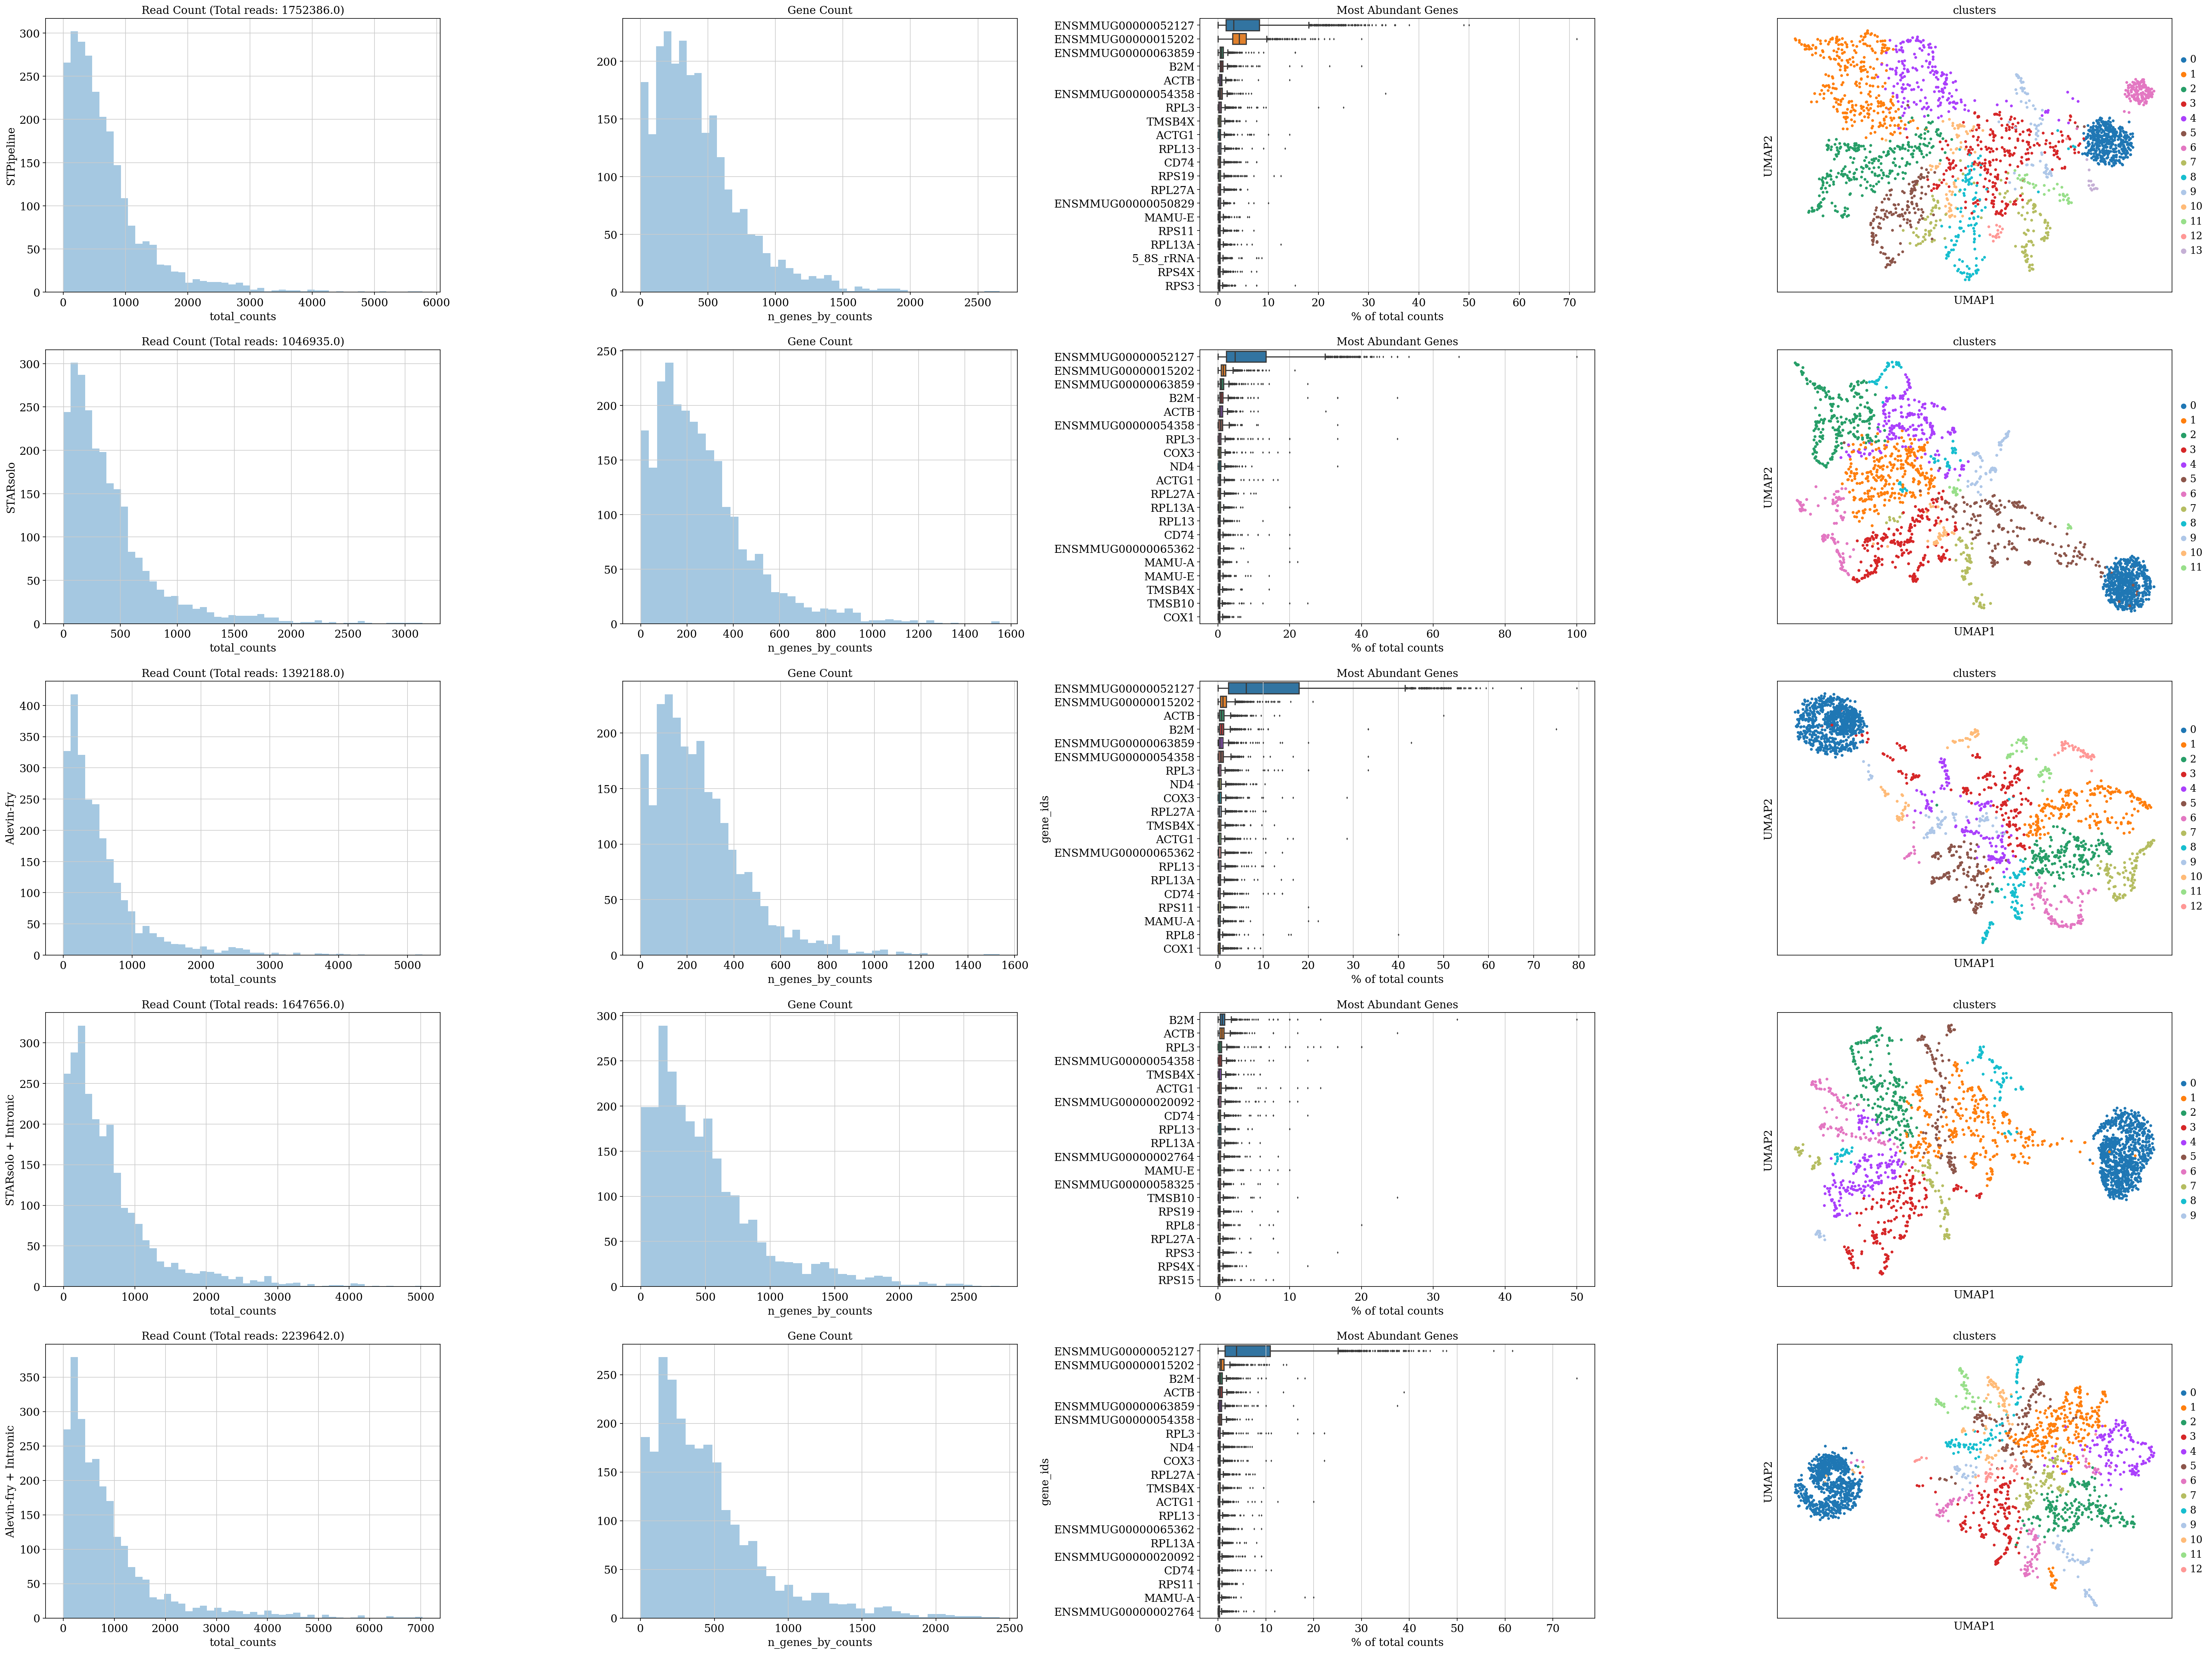

In [98]:
datas = {"STPipeline":adata_stp,
         "STARsolo":adata_star,
         "Alevin-fry":adata_alevin,
         "STARsolo + Intronic":adata_star_full,
         "Alevin-fry + Intronic":adata_alevin_full}

def generate_plots(adata, ax):
    # Plot 1 - Read Count
    sns.distplot(adata.obs["total_counts"], kde=False, ax=ax[0])
    ax[0].set_title(f'Read Count (Total reads: {adata.var["total_counts"].sum()})')

    # Plot 2 - Gene Count
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, ax=ax[1])
    ax[1].set_title(f'Gene Count')

    # Plot 3 - Most Abundant Genes
    sc.pl.highest_expr_genes(adata, n_top=20, ax=ax[2],show=False)
    ax[2].set_title(f'Most Abundant Genes')

    # Plot 4 - UMAPs
    sc.pp.filter_cells(adata, min_counts=100)
    sc.pp.filter_cells(adata, max_counts=35000)
    sc.pp.filter_genes(adata, min_cells=10)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=50)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added="clusters")

    sc.pl.umap(adata, color=["clusters"], wspace=0.4, ax=ax[3],show=False)

# Set up subplots
num_experiments = len(datas)
fig, axes = plt.subplots(num_experiments, 4, figsize=(40, 6 * num_experiments))

# Iterate over experiments and generate plots
for i, (experiment_name, experiment_data) in enumerate(datas.items()):
    generate_plots(experiment_data, axes[i, :])
    axes[i, 0].set_ylabel(experiment_name)

plt.tight_layout()
plt.show()